In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Cwiczenie 1 (3 pkt) - Kernelized Linear Regression

Dane pochodzą z rozkładu y_i = m*x_i + b + N(0, 1). 

Na podstawie 101 przykładów z rozkładu policz estymator MLE następującego modelu:

a) $$ p(y | x) = N(<x, w> + b, \sigma^2) = <x, w> + b + N(0, \sigma^2) $$. Równoważne $\phi(x) = [1, x]$ (patrz podpunkt b)

b) $$ p(y | x) = N(<\phi(x), w>, \sigma^2) = <\phi(x), w> + N(0, \sigma^2) $$, gdzie $\phi(x) = [1, x, x^2, x^3, x^4]$

Kod powinien być opakowany w klase ToyLinearRegression z metodami fit oraz predict. ToyLinearRegression powinien przyjmować w konstruktorze funkcję phi, która zamienia x na jego cechy, np phi(x) = [x] oznacza liniowy model.

In [2]:
from sklearn.linear_model import LinearRegression

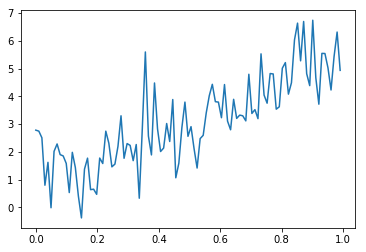

In [3]:
## Syntetyczny zbiór danych z dużym szumem ale liniowymi danymi
np.random.seed(123456789)

def y(x,m,b,mu=0,sigma=1.0): 
    return m*x + b + np.random.normal(mu,sigma,1)[0]

N = 101
M = 2
t = np.empty(N)
domain_bound = 1.0/N
domain = np.empty(N)

for i in range(N): 
    domain[i] = i*domain_bound
    
for i in range(N): 
    t[i] = y(x=domain[i],m=4.89,b=0.57)

plt.plot(domain, t)    

In [4]:
class ToyLinearRegression:
    def __init__(self, phi):
        self.phi = phi
    def fit(self, X, Y):
        phi_x = np.array([self.phi(x) for x in X])
        self.w = np.dot(np.linalg.inv(np.dot(phi_x.T, phi_x)), np.dot(phi_x.T, Y))
        return self
    def predict(self, X):
        phi_x = np.array([self.phi(x) for x in X])
        return np.dot(phi_x,self.w)
    
w_pred = ToyLinearRegression(phi=lambda x: [1, x]).fit(domain, t).w
assert np.abs(w_pred - np.array([0.88610652, 4.47519348])).max() < 0.05

## Cwiczenie 2 (4 pkt) - symulacja MAP 

W ostatnim zadaniu stworzyliśmy klasę ToyLinearRegression. W tym ćwiczeniu masz za zadanie oszacować jak będzie wyglądał posterior dla paru różnych rozkładów prior.

Niech prior będzie zdefiniowany poniższą funkcją. Niech $phi(x) = [1, x, x^2]$. Niech w[0]=0.88 na stałe. Niech sigma=1.0

a) Narysuj prior w[1] oraz w[2] (np. uzywajac meshgrid) dla C=1 i C=100 w zakresie [0, 10]. C=$\lambda^{-1}$, proszę też zobaczyć poniżej w definicji funkcji prior. Dodatkowy opis regularyzacji można także znaleźć w L4b "Estymator MAP"

b) Napisz funkcję o sygnaturze loglikelihood(w, X, Y, phi=lambda x: [1, x], sigma=1.0). 

c) Narysuj likelihood oraz posterior w[1] oraz w[2] dla C=0.1 i C=100 w zakresie [0, 10].  Dobierz tak sigma aby posterior miał wyraźny kształt "kulkowaty" jak na rysunku. 

d) Wyestymuj MAP oraz MLE dla C=0.1 i C=100. Co zauważyłeś? Z czego to wynika? (napisać)


### Hints

Hint: estymacja MAP/MLE polega na wybraniu argmaxa logposterior/loglikelihood po meshgrid

Hint: w c) nalezy liczyc *log* likelihood i *log* posterior

Hint: w d) uwaga, logposterior to nie ject loglikelihood*prior. Zastanowić się :)

Hint: funkcje prior należy wywoływać na całej macierzy punktów, nie tylko pojedynczych punktach. Będzie szybciej

### Co powinno wyjść

Prior: 

<img width=200 src="figures/L3/l3a_2_1.png">

C=100, od lewej: logprior/loglikelihood/logposterior: 

<img width=200 src="figures/L3/l3a_2_2.png">

C=0.1, od lewej: logprior/loglikelihood/logposterior: 

<img width=200 src="figures/L3/l3a_2_3.png">

In [5]:
import scipy
from scipy import stats
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [6]:
def prior(w, C, mean=[0.0, 3.0, 0.0]):
    assert w.ndim == 2
    
    sigma = np.zeros(shape=(w.shape[1], w.shape[1]))
    sigma[0,0] = 200 # Bias slabo zregularyzowany
    
    # Mozna ladniej zapisac
    for id in range(1, w.shape[1]):
        sigma[id, id] = C # Duze C -> malo zregularyzowany
        
    return scipy.stats.multivariate_normal.pdf(w,mean,sigma)

Prior:
C= 1


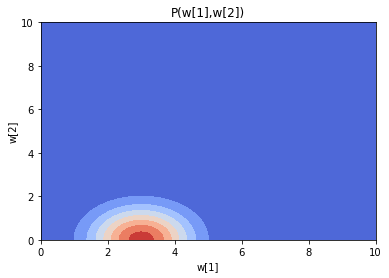

C = 100


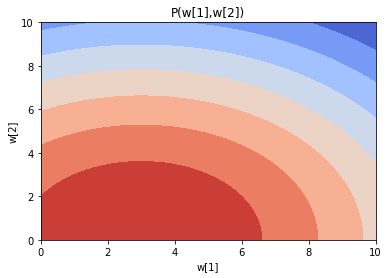

Logprior: 
C = 100


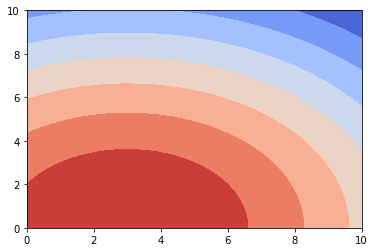

C = 0.1


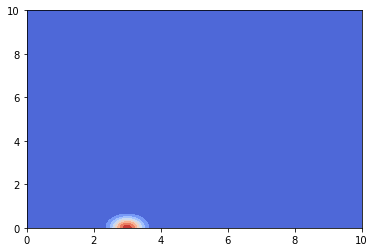

Loglikelihood: 
C = 100


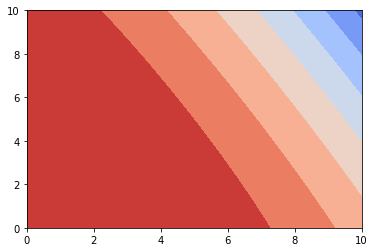

C = 0.1


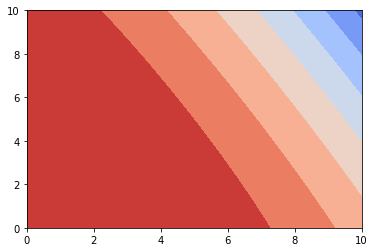

Logposterior: 
C = 100


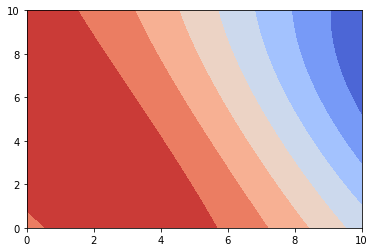

C = 0.1


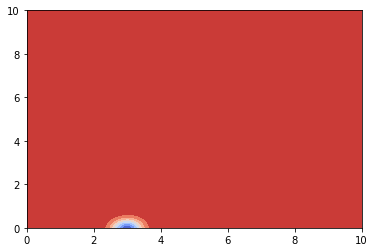

In [7]:
def loglikelihood(w, X, y, phi=lambda x: [1, x], sigma=1.0):
    phi_X = np.array([phi(x) for x in X])
    r = y-np.dot(phi_X, w)
    s = -1 * np.dot(r.T,r)
    return s
    
N=1000
w0 = 0.88
x = np.linspace(0, 10, N)
y = np.linspace(0, 10, N)
X, Y = np.meshgrid(x, y)

w = np.array([[w0, X[i,j], Y[i,j]] for i in range(N) for j in range(N)])
we = np.array([[X[i,j], Y[i,j]] for i in range(N) for j in range(N)])

def prior_plot(w, C):
    assert w.ndim == 2
    priors = prior(w, C)
    plt.contourf(x, y, priors.reshape((N,N)), cmap = "coolwarm")
    plt.title("P(w[1],w[2])")
    plt.xlabel("w[1]")
    plt.ylabel("w[2]")
    plt.show()

def lpri_plot(w, C):   
    assert w.ndim == 2
    priors = prior(w,C)
    plt.contourf(x, y, priors.reshape((N,N)),cmap = "coolwarm")
    plt.show()
    
def lp(w):
    assert w.ndim == 2
    res = []
    for wi in w:
        res.append(loglikelihood(wi, domain, t))
    return np.array(res)
    

def logl_plot(w, C):
    assert w.ndim == 2
    posteriors = lp(w)
    plt.contourf(x, y, posteriors.reshape((N,N)),cmap = "coolwarm")
    plt.show()

def lpos_plot(we, w, C):
    assert w.ndim == 2
    assert we.ndim == 2
    priors = prior(w,C)
    posteriors = lp(we)
    post = []
    for i in range(N**2):
        post.append(priors[i]*posteriors[i])
    plt.contourf(x, y, np.array(post).reshape((N,N)),cmap = "coolwarm")
    plt.show()

print("Prior:")
print("C= 1")
prior_plot(w,1)
print("C = 100")
prior_plot(w,100)

print('Logprior: ')
print('C = 100')
lpri_plot(w, 100)
print('C = 0.1')
lpri_plot(w, 0.1)

print('Loglikelihood: ')
print('C = 100')
logl_plot(we, 100)
print('C = 0.1')
logl_plot(we, 0.1)

print('Logposterior: ')
print('C = 100')
lpos_plot(we, w, 100)
print('C = 0.1')
lpos_plot(we, w, 0.1)

## Cwiczenie 3 (3 pkt) - MAP oraz co to znaczy dobra regularyzacja?

W tym ćwiczeniu Twoim zadaniem jest stworzenie klasy ToyBayesianLinearRegression, która nauczy model bayesowskiej regresji liniowej z wykorzystaniem liczenia bezposrednio wzoru na posterior.

Niech $phi(x) = [1, x, x^2]$, niech $sigma=1.0$

1. Podziel zbiór domain na zbiór trenujący i testujący uzywajac: ``X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1)``

2. Zmodyfikuj ToyLinearRegression aby używał wzorów na MAP [źródło: Bishop, albo http://kudkudak.github.io/assets/pdf/talks/gp.pdf, albo L4b sekcja "Estymator MAP"]. 

** Uwaga: nie należy regularyzować biasu! ** (czyli nie $\lambda I$ ale diag(0, 1/C, 1/C))

3. Policz wynik na zbiorze tesującym modelu nauczonego na zbiorze trenującym z C=0.1 oraz C=100

4. Które C jest lepsze i dlaczego? Upewnij się, że Twój argument uwzględnia to jaki jest *prawdziwy* model danych.

Hint: Wersja Bayesowska sprowadza się do *bardzo prostej modyfikacji ćw 1*

In [8]:
class ToyBayesianLinearRegression:
    def __init__(self, C, phi):
        self.C = C
        self.phi = phi
    def fit(self, X, Y):
        phi_x = np.array([self.phi(x) for x in X])
        sigma = np.zeros((3,3))
        for i in range(1,3):
            sigma[i,i] = 1 / self.C
        self.w = np.dot(np.linalg.inv(np.dot(phi_x.T, phi_x) + sigma), np.dot(phi_x.T, Y))
        return self
    def predict(self, X):
        phi_x = np.array([self.phi(x) for x in X])
        return np.dot(phi_x,self.w)

In [9]:
# 1. Maaala regularyzacja -> to samo co cw. 1. Polecam sprawdzic ze tak wychodzi w cw. 1 przy danym tutaj phi
w_pred = ToyBayesianLinearRegression(C=1000000, phi=lambda x: [1, x, x**2]).fit(domain, t).w
assert np.abs(w_pred - np.array([1.37, 1.475, 3.023])).max() < 0.05

# 2. Duza regularyzacja -> zabija obydwa
w_pred = ToyBayesianLinearRegression(C=0.01, phi=lambda x: [1, x, x**2]).fit(domain, t).w
assert np.abs(w_pred - np.array([2.832, 0.3217, 0.33])).max() < 0.05

# 3. Mala regularyzacja
w_pred = ToyBayesianLinearRegression(C=1, phi=lambda x: [1, x, x**2]).fit(domain, t).w
assert np.abs(w_pred - np.array([1.376, 1.944, 2.322])).max() < 0.05

In [10]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(domain, t, random_state=1)
model = ToyBayesianLinearRegression(C=100, phi=lambda x: [1, x, x**2]).fit(X_train, Y_train)
error = Y_test - model.predict(X_test)
print ('C = 100  error: ', sum(abs(error)))
model = ToyBayesianLinearRegression(C=0.01, phi=lambda x: [1, x, x**2]).fit(X_train, Y_train)
error = Y_test - model.predict(X_test)
print ('C = 0.01 error: ', sum(abs(error)))

C = 100  error:  19.6419974633
C = 0.01 error:  32.1417534204


/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
